# Channel estimation


Idea is to just send a training sequence twice in my channel; I'll then do the matrix computations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.special import erfc, erfcinv

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

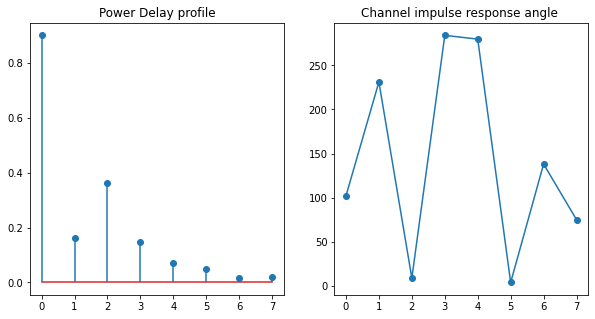

In [2]:



mat = scipy.io.loadmat('CIR.mat')
mat['h'].shape
CIR = mat['h']
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.stem(np.abs(CIR))

plt.title("Power Delay profile")

plt.subplot(122)
plt.title("Channel impulse response angle ")
plt.plot(((180/np.pi) * np.angle(CIR))%360, '-o')
plt.show()



In [3]:
ESNOdb = 20
sigs =  2 #Sigmasquare of signal
ESNO = 10**(ESNOdb/10)
var=sigs/(ESNO*2)
var = var * (144/128)
CP=16
K=128
#IDFT using sqrt ! important
def IDFT(OFDM_data):
    return np.sqrt(len(OFDM_data))*np.fft.ifft(OFDM_data)

#Add the CP 
def addCP(OFDM_time):
    cp = OFDM_time[-CP:]  
    return np.hstack([cp, OFDM_time]) 


def awgn(TX, var):
    num=len(TX)
    noisei = np.random.normal(0,np.sqrt(var),num)
    noisej = 1j*np.random.normal(0,np.sqrt(var),num)
    RX = TX[:]+noisei[:]+noisej[:]
    return RX
def conv_channel(TX, impresp):
    return np.convolve(TX,impresp)
    
def removeCP(signal):
    return signal[CP:(CP+K)]

#DFT according to idft
def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)/ np.sqrt(len(OFDM_RX))



In [4]:
import numpy as np
def DFT_matrix(N):
    i, j = np.meshgrid(np.arange(N), np.arange(N))
    omega = np.exp( - 2 * np.pi * 1J / N )
    W = np.power( omega, i * j )# / sqrt(N)
    return W

In [10]:
training = np.tile([1,-1],128//2)


def chann(IN, esno):
    ESNOdb = esno
    sigs =  2 #Sigmasquare of signal
    ESNO = 10**(ESNOdb/10)
    var=sigs/(ESNO*2)
    var = var * (144/128)
    bits = IDFT(training)
    bits = addCP(bits)

    bits = conv_channel(bits, CIR[:,0])

    bits = awgn(bits,var)

    bits = removeCP(bits)

    bits = DFT(bits)
    #plt.stem(bits)


    output1 = bits
    Y1 = np.asmatrix(np.reshape(output1, (128,1)))
    return Y1


esno=0
Y1 = chann(training,esno)
Y2 = chann(training,esno)



(8, 1)
(128, 1)
(8, 1)
(128, 1)


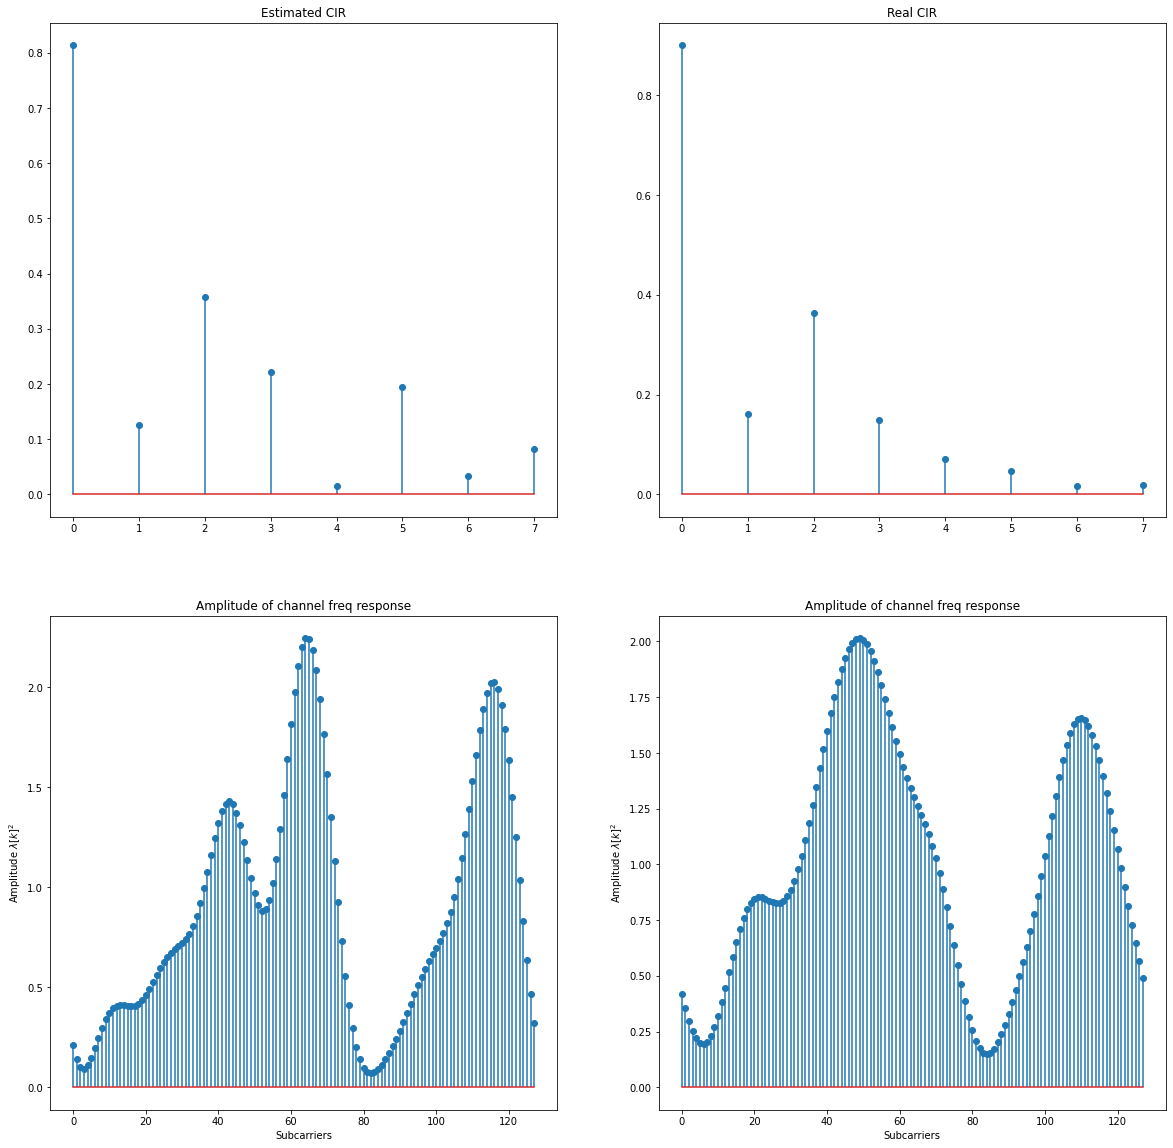

In [11]:
S = np.asmatrix(np.diag(training))
Mt = S@DFT_matrix(128)



M=Mt[:,:8]



H = (M.H@M + M.H@M)
H = np.linalg.inv(H)

P = (M.H@Y1 + M.H@Y2)
H = H@P

plt.figure(figsize=(20,20))
plt.subplot(221)
plt.title("Estimated CIR")
plt.stem(np.abs(H))

plt.subplot(222)
plt.title("Real CIR")
plt.stem(np.abs(CIR))

plt.subplot(224)
print(CIR.shape)
freqres = np.fft.fft(CIR,n=128, axis=0)
print(freqres.shape)
plt.stem(np.abs(freqres[:,:])**2)
plt.title("Amplitude of channel freq response")
plt.xlabel("Subcarriers")
plt.ylabel("Amplitude $\lambda [k]^2$")

plt.subplot(223)
print(CIR.shape)
freqres = np.fft.fft(H,n=128, axis=0)
print(freqres.shape)
plt.stem(np.abs(freqres[:,:])**2)
plt.title("Amplitude of channel freq response")
plt.xlabel("Subcarriers")
plt.ylabel("Amplitude $\lambda [k]^2$")

plt.show()

<StemContainer object of 3 artists>

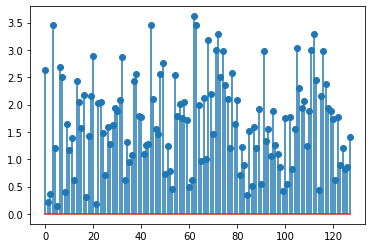

In [12]:
Est = S@Y1
plt.stem(np.abs(Est[:,0]))